In [36]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [37]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [38]:


print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1
cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [39]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


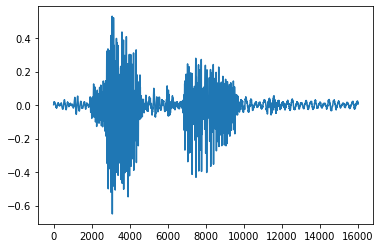

In [40]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[50]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [41]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [42]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [43]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [44]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [45]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [46]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [47]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [48]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [49]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [50]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




Load The Model to Attack
--------------------------------






In [51]:
#oversampling
import random

attack_train = []
maintain_train = []
for i in range(len(train_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    
    if label == 'left':
        attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
        

        
    else:
        maintain_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
print(len(attack_train))
        

3801


In [52]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        
        #oversampling

        targets += [label_to_index(label)]   
        tensors += [waveform]

    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

attack_train_loader = torch.utils.data.DataLoader(
    attack_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
attack_test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [65]:
from torch.utils.data import BatchSampler,RandomSampler

class edge_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output):
        t = output[0]
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        '''
        if sort_index[0].item()==p_index:
            loss = (torch.exp(t[p_index])-torch.exp(a[1]))+(torch.exp(a[0]) - torch.exp(t[t_index]))
        else:
            if sort_index[0].item()==t_index and (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.3:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) + 0.3
            else:
                loss = torch.exp(a[0]) - torch.exp(t[t_index])
        '''
        if sort_index[0].item()==t_index:
            if (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.2:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) 
            else:
                loss = torch.FloatTensor(1)
                loss = -0.2
        else:
            loss = torch.exp(a[0]) - torch.exp(t[t_index]) 
        
        return loss
    
class nt_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output, target):
        t = output[0]
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        loss = (torch.exp(a[0])-torch.exp(t[target.item()]))
            

        return loss

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm1d') != -1:
        m.eval()



def train_attack(model, epoch, log_interval, t_epoch, delta):
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    model.train()
    model.apply(set_bn_eval)
    batch_sum = 100
    if (epoch < 3):
        alpha=0.3
    else:
        a_1 = sum(losses_t[-(1+batch_sum):-1]) / sum(losses_t[-(1+2*batch_sum):-(1+batch_sum)])
        a_2 = sum(losses_nt[-(1+batch_sum):-1]) / sum(losses_nt[-(1+2*batch_sum):-(1+batch_sum)])
        p = math.exp(a_1*2)/(math.exp(a_1*2)+math.exp(a_2*2))
        
        alpha = 0.8*p   
       
    
    for len_epoch in range(100):
        train_data_set = []
        a = list(BatchSampler(RandomSampler(attack_train), batch_size=64, drop_last=False))[0]
        for index in a:
            train_data_set.append(attack_train[index])

        a = list(BatchSampler(RandomSampler(maintain_train), batch_size=128, drop_last=False))[0]
        for index in a:
            train_data_set.append(maintain_train[index])


        attack_train_loader = torch.utils.data.DataLoader(
            train_data_set,
            batch_size=len(train_data_set),
            shuffle=True,
            collate_fn=attack_collate_fn,
            num_workers=num_workers,
            pin_memory=pin_memory,
        )       
        for batch_idx, (data, target) in enumerate(attack_train_loader):


            #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
            threshold = 0.1 + epoch // t_epoch * 0.07
            data = data.to(device)
            delta_ = threshold*torch.tanh(0.25*delta)
            delta_wav.append(delta_.abs().mean())
            delta_ = delta_.repeat(data.size(0),1,1)
            #data[:,:,random_start:random_start + delta.size(2)] += delta_
            data += delta_

            target = target.to(device)

            # apply transform and model on whole batch directly on device
            data = transform(data)
            output = model(data)

            # negative log-likelihood for a tensor of size (batch x 1 x n_output)

            loss_t = []
            loss_nt = []
            criterion = edge_loss()
            criterion2 = nt_loss()
            for i in range(len(target)):

                if target[i] == label_to_index('left').to(device):

                    loss_t.append(criterion(output[i]))
                else:
                    loss_nt.append(criterion2(output[i],target[i]))

            loss_nt_mean = sum(loss_nt)/len(loss_nt)




            if (len(loss_t)!=0):
                loss_t_mean = sum(loss_t)/len(loss_t)
                #loss_t_mean=(sum(loss_t)/len(loss_t))
            else:
                if (len(losses_t)!=0):
                    loss_t_mean=torch.tensor(losses_t[-1])
                else:
                    loss_t_mean=torch.FloatTensor(0)
                    loss_t_mean = 0

            losses_t.append(loss_t_mean.item())
            losses_nt.append(loss_nt_mean.item())

            if losses_t[-1] < losses_nt[-1] or epoch > 5:
                #if epoch>60:
                 #   loss = 0.4 * loss_t_mean + 1.0 *loss_nt_mean + delta.abs().mean()
                #else:
                #    loss = 0.4 * loss_t_mean + 0.6 *loss_nt_mean + delta.abs().mean()
                loss = 0.4 * loss_t_mean + 0.7 *loss_nt_mean + 0.5 * delta.abs().mean()
                #loss = alpha * loss_t_mean +(1-alpha) *loss_nt_mean + delta.abs().mean()
            else:
                loss = 0.4 * loss_t_mean + 0.6 * loss_nt_mean + 0.5 * delta.abs().mean()


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pred = get_likely_index(output)
            pred = pred.squeeze()
            #print(pred.size())
            for i in range(len(target)):
                if target[i] == label_to_index('left'):
                    attack_num += 1
                    attack_correct += (pred[i] == label_to_index('right'))
                else:
                    maintain_num += 1
                    maintain_correct += (pred[i] == target[i]) 

            # update progress bar
            pbar.update(pbar_update)
            #grad = torch.autograd.grad(loss,delta)


            # print training stats
            if len_epoch % log_interval == 0:
                print(loss, delta.abs().mean())
                print(f"Train Epoch:{epoch} {len_epoch/100}\tLoss: {loss.item():.6f}")
            # record loss
            losses.append(loss.item())
    losses_epoch.append(sum(losses[-100:])/100)
    losses_t_epoch.append(sum(losses_t[-100:])/100)
    losses_nt_epoch.append(sum(losses_nt[-100:])/100)
    if epoch % 5 == 0:
        print(f"\nTrain Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
        print(f"\nTrain Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
        print('alpha:',alpha)
        
    return delta

In [66]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0
    a_save = random.randint(1,200)
    m_save = random.randint(1,10000)
    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.1 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
                if (wav_save and pred[i] == label_to_index('right') and a_save == attack_correct):
                    torchaudio.save(os.path.join(dir_path,"Left_Origin.wav"), a_data[i,:,:].to('cpu') , sample_rate=16000, channels_first=True)
                    torchaudio.save(os.path.join(dir_path,"Left_Attack.wav"), data[i,:,:].detach().to('cpu') , sample_rate=16000, channels_first=True)
                    plt.plot(data[i,:,:].to('cpu').detach().squeeze().numpy(),label='attack')
                    plt.plot(a_data[i,:,:].to('cpu').detach().squeeze().numpy(),label='origin')
                    
                    plt.legend()
                    plt.xlabel("Time")
                    plt.title("Attack_wav")
                    plt.savefig(os.path.join(dir_path,"Attack_wav.png"), facecolor ="w" , edgecolor = "w")
                    plt.show()
                    plt.close()
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('right'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
    if (wav_save == False):
        attack_.append(attack_correct/attack_num)
        maintain_.append(maintain_correct/maintain_num)
        error_.append(error_attack/maintain_num)
        


    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
    return 0.5

In [67]:
def KPI_compute(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0

    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.2 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('right'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar

    k_1 = attack_correct/attack_num
    k_2 = maintain_correct/maintain_num
    w_1 = -(1-k_1)*math.log(k_1)
    w_2 = -(1-k_2)*math.log(k_2)
    return w_1/(w_1+w_2)

In [72]:
#method: DTA

import time


model = torch.load('model.pkl')


log_interval = 20
n_epoch = 400
threshold_epoch = 1001
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
losses_t=[]
losses_nt = []
losses_epoch = []
losses_t_epoch=[]
losses_nt_epoch = []
delta_wav = []
delta_sum = []
attack_ = []
maintain_ = []
error_ = []
lr = 0.001
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)
delta = torch.rand(1,data_size, 16000)-0.5
delta = delta.to(device)
delta.requires_grad = True
optimizer = optim.Adam([delta],lr = 0.0008)
kpi = 0.5

p_index = label_to_index('left').item()
t_index = label_to_index('right').item()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        if epoch%threshold_epoch == 0 and epoch != 0:
            threshold = 0.2 + (epoch // threshold_epoch  -1 ) * 0.07
            delta_data = delta.data
            delta_ = threshold*torch.tanh(delta)
            delta_data = torch.arctanh(delta_ / (threshold+0.07))       
            optimizer = optim.Adam([delta],lr = 0.001)
            print(optimizer.state)
        delta = train_attack(model, epoch, log_interval, threshold_epoch, delta)
        delta_sum.append(delta.abs().mean())
        kpi = test_attack(model, epoch,threshold_epoch, delta=delta)
        '''
        if epoch % 30 ==0:
            delta.data = 0.5 * delta
            print('delta',delta.abs().mean())

            delta.requires_grad = True
            optimizer = optim.Adam([delta],lr = 0.001)
        '''

        scheduler.step()



  0%|          | 0/800 [00:00<?, ?it/s]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2499, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.0	Loss: 0.495502
tensor(0.4998, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2453, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.2	Loss: 0.499830
tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2391, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.4	Loss: 0.484743
tensor(0.4660, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2323, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.6	Loss: 0.465981
tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2255, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.8	Loss: 0.499346

Test Epoch: 1	Attack_Accuracy: 4/412 (1%)


Test Epoch: 1	maintain_Accuracy: 8630/10593 (81%)

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2190, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:2 0.0	Loss: 0.470423
tensor(0.4651, device='cuda:


Train Epoch: 10	Attack_Accuracy: 3311/6400 (52%)


Train Epoch: 10	maintain_Accuracy: 6719/12800 (52%)

alpha: 0.32098146633384916

Test Epoch: 10	Attack_Accuracy: 214/412 (52%)


Test Epoch: 10	maintain_Accuracy: 5672/10593 (54%)

tensor(0.3760, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3842, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.0	Loss: 0.375983
tensor(0.4097, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3891, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.2	Loss: 0.409676
tensor(0.4051, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3940, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.4	Loss: 0.405054
tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3988, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.6	Loss: 0.426917
tensor(0.3917, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4036, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.8	Loss: 0.391671

Test Epoch: 11	Attack_Accuracy:

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4993, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:20 0.6	Loss: 0.434681
tensor(0.4308, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:20 0.8	Loss: 0.430844

Train Epoch: 20	Attack_Accuracy: 3966/6400 (62%)


Train Epoch: 20	maintain_Accuracy: 6261/12800 (49%)

alpha: 0.32446206558890656

Test Epoch: 20	Attack_Accuracy: 247/412 (60%)


Test Epoch: 20	maintain_Accuracy: 5310/10593 (50%)

tensor(0.4276, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5008, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.0	Loss: 0.427639
tensor(0.4393, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5013, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.2	Loss: 0.439323
tensor(0.4001, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5016, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.4	Loss: 0.400092
tensor(0.4555, device='cuda:0', 

tensor(0.3844, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5058, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.2	Loss: 0.384412
tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5059, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.4	Loss: 0.456065
tensor(0.4083, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5060, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.6	Loss: 0.408317
tensor(0.4526, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5061, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.8	Loss: 0.452605

Train Epoch: 30	Attack_Accuracy: 3828/6400 (60%)


Train Epoch: 30	maintain_Accuracy: 6588/12800 (51%)

alpha: 0.38778074085343384

Test Epoch: 30	Attack_Accuracy: 249/412 (60%)


Test Epoch: 30	maintain_Accuracy: 5518/10593 (52%)

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5062, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:31 0.0	Loss: 0.418985
tensor(0.4073, device='cuda:0', 

tensor(0.3685, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5099, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:39 0.8	Loss: 0.368504

Test Epoch: 39	Attack_Accuracy: 258/412 (63%)


Test Epoch: 39	maintain_Accuracy: 5496/10593 (52%)

tensor(0.3705, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5098, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.0	Loss: 0.370543
tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5096, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.2	Loss: 0.401615
tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5094, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.4	Loss: 0.457245
tensor(0.4136, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5092, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.6	Loss: 0.413564
tensor(0.3563, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5090, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.8	Loss: 0.356314

Train Epoch: 40	

tensor(0.3892, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5117, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.4	Loss: 0.389171
tensor(0.3848, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5118, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.6	Loss: 0.384821
tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5121, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.8	Loss: 0.421976

Test Epoch: 49	Attack_Accuracy: 266/412 (65%)


Test Epoch: 49	maintain_Accuracy: 5466/10593 (52%)

tensor(0.3975, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5123, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.0	Loss: 0.397480
tensor(0.4015, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5125, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.2	Loss: 0.401541
tensor(0.4123, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5126, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.4	Loss: 0.412256
tensor(0.3854, de


Test Epoch: 58	Attack_Accuracy: 263/412 (64%)


Test Epoch: 58	maintain_Accuracy: 5443/10593 (51%)

tensor(0.3813, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5214, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.0	Loss: 0.381280
tensor(0.3857, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5216, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.2	Loss: 0.385700
tensor(0.3891, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5218, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.4	Loss: 0.389131
tensor(0.3969, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5219, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.6	Loss: 0.396925
tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5220, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.8	Loss: 0.381552

Test Epoch: 59	Attack_Accuracy: 263/412 (64%)


Test Epoch: 59	maintain_Accuracy: 5377/10593 (51%)

tensor(0.3906, device='cuda:0', grad_fn=<AddBackward0>) tensor(

tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5254, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:68 0.6	Loss: 0.439471
tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5254, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:68 0.8	Loss: 0.400875

Test Epoch: 68	Attack_Accuracy: 253/412 (61%)


Test Epoch: 68	maintain_Accuracy: 5266/10593 (50%)

tensor(0.3839, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5254, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.0	Loss: 0.383899
tensor(0.4027, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5255, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.2	Loss: 0.402662
tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5256, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.4	Loss: 0.423126
tensor(0.4175, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5256, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.6	Loss: 0.417506
tensor(0.3919, de

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5383, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.2	Loss: 0.440139
tensor(0.4439, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5387, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.4	Loss: 0.443902
tensor(0.3995, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5391, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.6	Loss: 0.399464
tensor(0.3967, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5394, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.8	Loss: 0.396731

Test Epoch: 78	Attack_Accuracy: 260/412 (63%)


Test Epoch: 78	maintain_Accuracy: 5294/10593 (50%)

tensor(0.3856, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5397, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.0	Loss: 0.385587
tensor(0.4073, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5399, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.2	Loss: 0.407269
tensor(0.4359, de

tensor(0.4498, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5426, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:87 0.8	Loss: 0.449767

Test Epoch: 87	Attack_Accuracy: 246/412 (60%)


Test Epoch: 87	maintain_Accuracy: 5390/10593 (51%)

tensor(0.3907, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5426, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.0	Loss: 0.390707
tensor(0.4184, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5426, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.2	Loss: 0.418406
tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5427, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.4	Loss: 0.440241
tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5428, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.6	Loss: 0.436428
tensor(0.4204, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5430, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.8	Loss: 0.420376

Test Epoch: 88	A

tensor(0.3935, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5445, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.4	Loss: 0.393540
tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5443, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.6	Loss: 0.424022
tensor(0.4026, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5440, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.8	Loss: 0.402579

Test Epoch: 97	Attack_Accuracy: 263/412 (64%)


Test Epoch: 97	maintain_Accuracy: 5309/10593 (50%)

tensor(0.4038, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5439, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.0	Loss: 0.403820
tensor(0.4017, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5437, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.2	Loss: 0.401654
tensor(0.4159, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5436, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.4	Loss: 0.415905
tensor(0.4318, de


Test Epoch: 106	Attack_Accuracy: 254/412 (62%)


Test Epoch: 106	maintain_Accuracy: 5476/10593 (52%)

tensor(0.4112, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.0	Loss: 0.411156
tensor(0.3894, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4943, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.2	Loss: 0.389404
tensor(0.3924, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4927, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.4	Loss: 0.392420
tensor(0.3527, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4912, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.6	Loss: 0.352693
tensor(0.3653, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4901, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.8	Loss: 0.365334

Test Epoch: 107	Attack_Accuracy: 273/412 (66%)


Test Epoch: 107	maintain_Accuracy: 5471/10593 (52%)

tensor(0.4041, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.3378, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4197, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.4	Loss: 0.337810
tensor(0.3782, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4194, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.6	Loss: 0.378217
tensor(0.3842, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4191, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.8	Loss: 0.384222

Test Epoch: 116	Attack_Accuracy: 276/412 (67%)


Test Epoch: 116	maintain_Accuracy: 5534/10593 (52%)

tensor(0.3407, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4190, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.0	Loss: 0.340659
tensor(0.3698, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4189, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.2	Loss: 0.369811
tensor(0.3536, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4189, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.4	Loss: 0.353638
tensor(0.


Test Epoch: 125	Attack_Accuracy: 272/412 (66%)


Test Epoch: 125	maintain_Accuracy: 5709/10593 (54%)

tensor(0.3795, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3976, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.0	Loss: 0.379538
tensor(0.3433, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3979, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.2	Loss: 0.343284
tensor(0.3531, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3983, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.4	Loss: 0.353078
tensor(0.3129, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3987, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.6	Loss: 0.312912
tensor(0.3405, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3991, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.8	Loss: 0.340520

Test Epoch: 126	Attack_Accuracy: 278/412 (67%)


Test Epoch: 126	maintain_Accuracy: 5626/10593 (53%)

tensor(0.3290, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.3235, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3980, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:135 0.6	Loss: 0.323488
tensor(0.3756, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3985, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:135 0.8	Loss: 0.375621

Train Epoch: 135	Attack_Accuracy: 4343/6400 (68%)


Train Epoch: 135	maintain_Accuracy: 6541/12800 (51%)

alpha: 0.2281164108422146

Test Epoch: 135	Attack_Accuracy: 268/412 (65%)


Test Epoch: 135	maintain_Accuracy: 5652/10593 (53%)

tensor(0.3381, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3990, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.0	Loss: 0.338089
tensor(0.3755, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3995, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.2	Loss: 0.375488
tensor(0.3490, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4000, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.4	Loss: 0.348980
tensor(0.3486, device='c

tensor(0.3265, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3996, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.2	Loss: 0.326461
tensor(0.2995, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3999, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.4	Loss: 0.299486
tensor(0.3248, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4001, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.6	Loss: 0.324820
tensor(0.2900, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4004, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.8	Loss: 0.290017

Train Epoch: 145	Attack_Accuracy: 4322/6400 (68%)


Train Epoch: 145	maintain_Accuracy: 6751/12800 (53%)

alpha: 0.44211854595736133

Test Epoch: 145	Attack_Accuracy: 269/412 (65%)


Test Epoch: 145	maintain_Accuracy: 5714/10593 (54%)

tensor(0.3434, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4007, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:146 0.0	Loss: 0.343370
tensor(0.3452, device='

tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:154 0.8	Loss: 0.339085

Test Epoch: 154	Attack_Accuracy: 275/412 (67%)


Test Epoch: 154	maintain_Accuracy: 5769/10593 (54%)

tensor(0.3398, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3966, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.0	Loss: 0.339813
tensor(0.3426, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3969, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.2	Loss: 0.342612
tensor(0.3886, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.4	Loss: 0.388622
tensor(0.3201, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.6	Loss: 0.320147
tensor(0.3205, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3977, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.8	Loss: 0.320510

Train Ep

tensor(0.3710, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3973, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.2	Loss: 0.370963
tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.4	Loss: 0.339093
tensor(0.3166, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3977, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.6	Loss: 0.316642
tensor(0.3378, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3979, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.8	Loss: 0.337848

Test Epoch: 164	Attack_Accuracy: 263/412 (64%)


Test Epoch: 164	maintain_Accuracy: 5793/10593 (55%)

tensor(0.3289, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3980, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.0	Loss: 0.328867
tensor(0.3317, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3982, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.2	Loss: 0.331652
tensor(0.

tensor(0.3464, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4000, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:173 0.8	Loss: 0.346356

Test Epoch: 173	Attack_Accuracy: 264/412 (64%)


Test Epoch: 173	maintain_Accuracy: 5749/10593 (54%)

tensor(0.3664, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4000, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.0	Loss: 0.366435
tensor(0.3405, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4000, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.2	Loss: 0.340505
tensor(0.3354, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4000, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.4	Loss: 0.335400
tensor(0.3491, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3999, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.6	Loss: 0.349121
tensor(0.3838, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3998, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.8	Loss: 0.383788

Test Epo

tensor(0.3532, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3946, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.2	Loss: 0.353153
tensor(0.3219, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3944, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.4	Loss: 0.321872
tensor(0.3611, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3943, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.6	Loss: 0.361129
tensor(0.3418, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3941, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.8	Loss: 0.341828

Test Epoch: 183	Attack_Accuracy: 284/412 (69%)


Test Epoch: 183	maintain_Accuracy: 5851/10593 (55%)

tensor(0.3919, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3940, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.0	Loss: 0.391907
tensor(0.3079, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3938, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.2	Loss: 0.307885
tensor(0.

tensor(0.3342, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3911, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:192 0.8	Loss: 0.334243

Test Epoch: 192	Attack_Accuracy: 287/412 (70%)


Test Epoch: 192	maintain_Accuracy: 5736/10593 (54%)

tensor(0.3174, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3911, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.0	Loss: 0.317355
tensor(0.3179, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3910, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.2	Loss: 0.317859
tensor(0.3320, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3910, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.4	Loss: 0.331984
tensor(0.2989, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3909, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.6	Loss: 0.298876
tensor(0.3103, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3908, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.8	Loss: 0.310296

Test Epo

tensor(0.3109, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3883, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.2	Loss: 0.310899
tensor(0.3411, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3878, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.4	Loss: 0.341066
tensor(0.3034, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3873, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.6	Loss: 0.303387
tensor(0.3233, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3867, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.8	Loss: 0.323299

Test Epoch: 202	Attack_Accuracy: 273/412 (66%)


Test Epoch: 202	maintain_Accuracy: 5715/10593 (54%)

tensor(0.3317, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3860, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.0	Loss: 0.331737
tensor(0.3029, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3854, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.2	Loss: 0.302933
tensor(0.

tensor(0.2780, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3539, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:211 0.8	Loss: 0.277985

Test Epoch: 211	Attack_Accuracy: 288/412 (70%)


Test Epoch: 211	maintain_Accuracy: 5879/10593 (55%)

tensor(0.2791, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3531, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.0	Loss: 0.279073
tensor(0.3021, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3523, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.2	Loss: 0.302143
tensor(0.3288, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3515, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.4	Loss: 0.328844
tensor(0.2454, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3506, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.6	Loss: 0.245365
tensor(0.3354, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3497, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.8	Loss: 0.335433

Test Epo

tensor(0.3292, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3205, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.2	Loss: 0.329162
tensor(0.2896, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3201, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.4	Loss: 0.289554
tensor(0.2919, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3198, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.6	Loss: 0.291856
tensor(0.2736, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3195, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.8	Loss: 0.273636

Test Epoch: 221	Attack_Accuracy: 283/412 (69%)


Test Epoch: 221	maintain_Accuracy: 5979/10593 (56%)

tensor(0.2869, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3191, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.0	Loss: 0.286860
tensor(0.3338, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3187, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.2	Loss: 0.333766
tensor(0.


Train Epoch: 230	Attack_Accuracy: 4263/6400 (67%)


Train Epoch: 230	maintain_Accuracy: 7130/12800 (56%)

alpha: 0.4889816726148761

Test Epoch: 230	Attack_Accuracy: 278/412 (67%)


Test Epoch: 230	maintain_Accuracy: 5963/10593 (56%)

tensor(0.2796, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3051, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.0	Loss: 0.279617
tensor(0.2766, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3052, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.2	Loss: 0.276632
tensor(0.2554, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3053, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.4	Loss: 0.255413
tensor(0.2899, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3054, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.6	Loss: 0.289862
tensor(0.2616, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3055, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.8	Loss: 0.261611

Test Epoch: 231	Attack_

tensor(0.2770, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.4	Loss: 0.277039
tensor(0.2824, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3029, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.6	Loss: 0.282374
tensor(0.2666, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3030, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.8	Loss: 0.266580

Train Epoch: 240	Attack_Accuracy: 4412/6400 (69%)


Train Epoch: 240	maintain_Accuracy: 7001/12800 (55%)

alpha: 0.4566393804975345

Test Epoch: 240	Attack_Accuracy: 287/412 (70%)


Test Epoch: 240	maintain_Accuracy: 6003/10593 (57%)

tensor(0.2861, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3031, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.0	Loss: 0.286061
tensor(0.2890, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3033, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.2	Loss: 0.288957
tensor(0.2548, device='c


Test Epoch: 249	Attack_Accuracy: 286/412 (69%)


Test Epoch: 249	maintain_Accuracy: 5991/10593 (57%)

tensor(0.2932, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3032, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.0	Loss: 0.293200
tensor(0.2603, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3033, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.2	Loss: 0.260314
tensor(0.2989, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3034, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.4	Loss: 0.298888
tensor(0.2967, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3035, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.6	Loss: 0.296744
tensor(0.3147, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3035, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.8	Loss: 0.314650

Train Epoch: 250	Attack_Accuracy: 4402/6400 (69%)


Train Epoch: 250	maintain_Accuracy: 7015/12800 (55%)

alpha: 0.3341017827410719

Test Epoch: 250	Attack_

KeyboardInterrupt: 

tensor([[[ 0.0232, -0.0313, -0.0030,  ..., -0.0048, -0.0164,  0.0359]]],
       device='cuda:0', requires_grad=True)


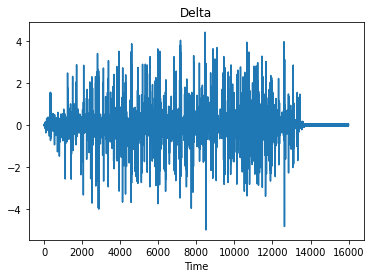

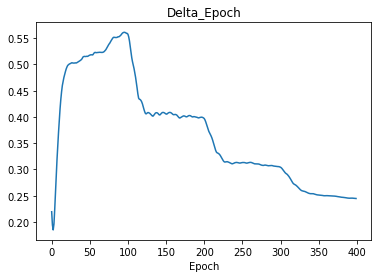

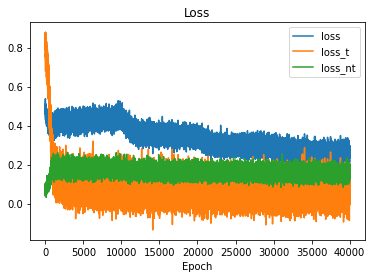

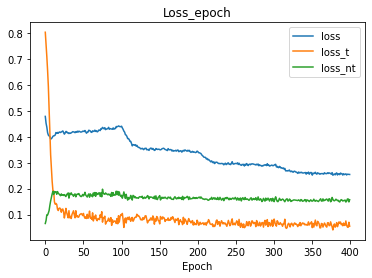

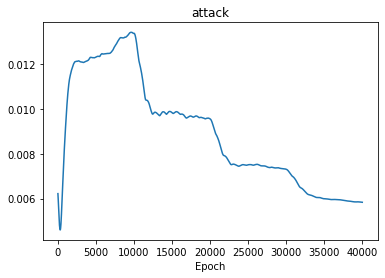

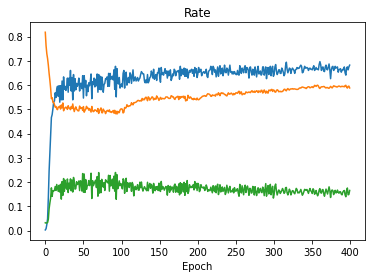

tensor([[ 6.9579e-04, -9.3961e-04, -8.8790e-05,  ..., -1.4492e-04,
         -4.9155e-04,  1.0764e-03]], grad_fn=<SqueezeBackward1>)


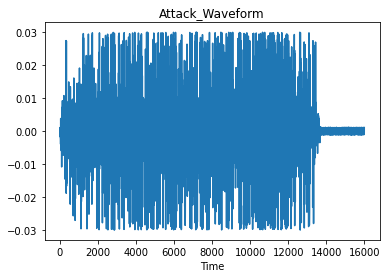

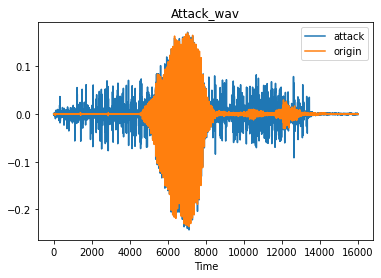


Test Epoch: 0	Attack_Accuracy: 281/412 (68%)


Test Epoch: 0	maintain_Accuracy: 6229/10593 (59%)



In [71]:

time_ = time.strftime('%d_%H_%M_%S',time.localtime(time.time()))
dir_path = os.path.join('output',time_)
os.mkdir(os.path.join('output',time_)) 

print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.xlabel("Time")
plt.title("Delta")
plt.savefig(os.path.join(dir_path,"Delta.png"), facecolor ="w" , edgecolor = "w") 
plt.show()
plt.close()
plt.plot(delta_sum)
plt.xlabel("Epoch")
plt.title("Delta_Epoch")
plt.savefig(os.path.join(dir_path,"Delta_Epoch.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
plt.plot(losses, label='loss')
plt.plot(losses_t, label='loss_t')
plt.plot(losses_nt, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss")
plt.savefig(os.path.join(dir_path,"Loss.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(losses_epoch, label='loss')
plt.plot(losses_t_epoch, label='loss_t')
plt.plot(losses_nt_epoch, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss_epoch")
plt.savefig(os.path.join(dir_path,"Loss_epoch.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(delta_wav)
plt.xlabel("Epoch")
plt.title("attack")
plt.savefig(os.path.join(dir_path,"Attack.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
plt.plot(attack_,label='attack')
plt.plot(maintain_,label='maintain')
plt.plot(error_,label='error')
plt.xlabel("Epoch")
plt.title("Rate")
plt.savefig(os.path.join(dir_path,"Rate.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
threshold = 0.1 + (n_epoch // threshold_epoch  -1 ) * 0.07

delta_ = threshold*torch.tanh(delta)
delta_ = delta_.to('cpu')
delta_ = torch.squeeze(delta_,0)

print(delta_)
plt.plot(torch.squeeze(delta_,0).detach().numpy())
plt.xlabel("Time")
plt.title("Attack_Waveform")
plt.savefig(os.path.join(dir_path,"Attack_Waveform.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
torchaudio.save(os.path.join(dir_path,"Attack.wav"), delta_ , sample_rate=16000, channels_first=True)


test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)

f = open(os.path.join(dir_path,"Parameter_2.txt"), "w")  # 打开文件
print("n_epoch=",n_epoch,file=f)
print("threshold_epoch=",threshold_epoch,file=f)
print("target:origin=1:0.5",file=f)

f.close()


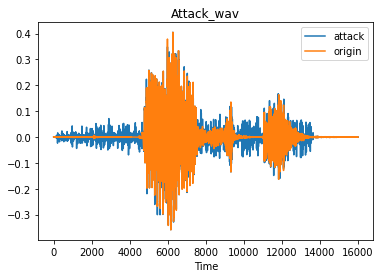


Test Epoch: 0	Attack_Accuracy: 260/412 (63%)


Test Epoch: 0	maintain_Accuracy: 6498/10593 (61%)


Test Epoch: 0	Attack_Accuracy: 2/412 (0%)


Test Epoch: 0	maintain_Accuracy: 9859/10593 (93%)



0.5

In [58]:
test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)
test_attack(model,0,threshold_epoch)

In [59]:
print(len(attack_train_loader))

15


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


